In [1]:
# Full example for my blog post at:
# https://danijar.com/building-variational-auto-encoders-in-tensorflow/

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import sys
tfd = tf.contrib.distributions

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -765.4892
Epoch 1 elbo -743.01807
Epoch 2 elbo -742.2814
Epoch 3 elbo -741.7118
Epoch 4 elbo -741.5554
Epoch 5 elbo -741.2958
Epoch 6 elbo -741.1452
Epoch 7 elbo -741.0281
Epoch 8 elbo -740.8273
Epoch 9 elbo -740.7842


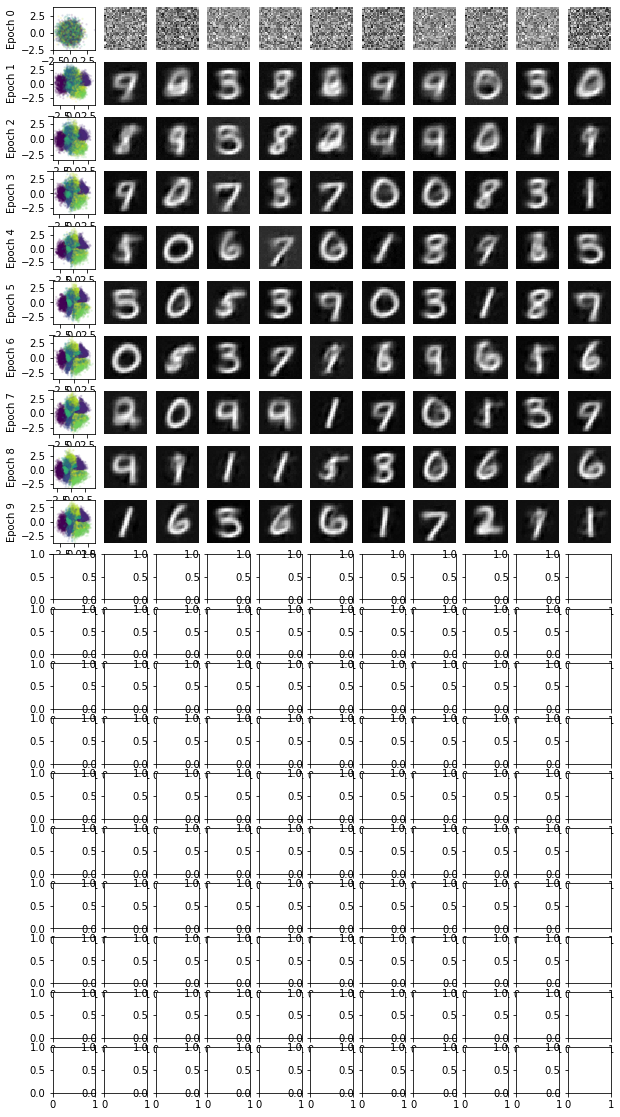

In [2]:
# Full example for my blog post at:
# https://danijar.com/building-variational-auto-encoders-in-tensorflow/

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tfd = tf.contrib.distributions


def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    loc = tf.layers.dense(x, code_size)
    scale = tf.layers.dense(x, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)


def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)


def make_decoder(code, data_shape):
    x = code
    x = tf.layers.dense(x, 256, tf.nn.relu)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    #logit = tf.layers.dense(x, np.prod(data_shape))
    #logit = tf.reshape(logit, [-1] + data_shape)
    #return tfd.Independent(tfd.Bernoulli(logit), 2)
    loc = tf.layers.dense(x, 28*28)
    #scale = tf.layers.dense(x, 28*28, tf.nn.softplus)
    scale = tf.ones(28*28)
    loc = tf.reshape(loc, [-1] + data_shape)
    scale = tf.reshape(scale, [-1] + data_shape)
    return tfd.Independent(tfd.MultivariateNormalDiag(loc, scale))


def plot_codes(ax, codes, labels):
    ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlim(codes.min() - .1, codes.max() + .1)
    ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.tick_params(
        axis='both', which='both', left='off', bottom='off',
        labelleft='off', labelbottom='off')


def plot_samples(ax, samples):
    for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')


data = tf.placeholder(tf.float32, [None, 28, 28])

make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Define the model.
prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)
init_op = tf.initialize_all_variables()

samples = make_decoder(prior.sample(10), [28, 28]).mean()

mnist = input_data.read_data_sets('MNIST_data/')
fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))

with tf.train.MonitoredSession() as sess:
    sess.run(init_op)
    for epoch in range(10):
        feed = {data: mnist.test.images.reshape([-1, 28, 28])}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        print('Epoch', epoch, 'elbo', test_elbo)
        ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        plot_codes(ax[epoch, 0], test_codes, mnist.test.labels)
        plot_samples(ax[epoch, 1:], test_samples)
        for _ in range(600):
            feed = {data: mnist.train.next_batch(128)[0].reshape([-1, 28, 28])}
            sess.run(optimize, feed)
plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')